# Neural Network


![Neural Network](https://miro.medium.com/0*lDbXVQhmjtlHjzKC.png)

![NN](https://media.geeksforgeeks.org/wp-content/uploads/20240916160154/234.webp)

### Data Retreival and Collection



In [184]:
import pandas as pd

path = r'binary_classification_moons.csv'

data = pd.read_csv(path)
data.head(6)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1


### Data Cleaning 

In [185]:
data.describe()

,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,0.499552,0.249196,0.50000
std,0.867371,0.494822,0.50025
min,-1.061751,-0.571697,0.00000
25%,-0.019860,-0.216408,0.00000
50%,0.502008,0.248686,0.50000
75%,1.020851,0.694288,1.00000
max,2.064637,1.042677,1.00000


Here, the data is clean, so no additional preprocessing steps are required.



### Feature Design

In NN, feature desisn is an automatic step. 

### Algorithm Selection

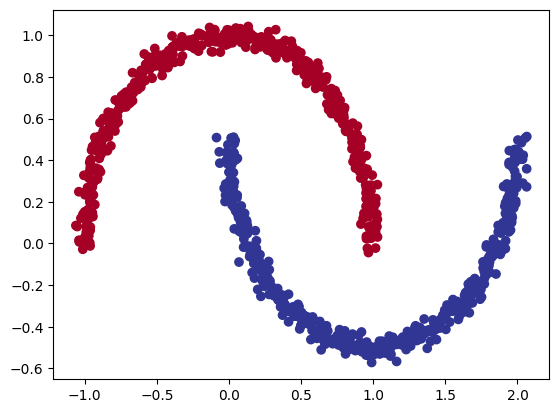

In [186]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=data.X1, 
            y=data.X2, 
            c=data.label, 
            cmap=plt.cm.RdYlBu
            );

In [187]:
# vectorizing X1 and X2 into a single tensor/nparray

X = data[['X1', 'X2']].values
y = data['label'].values

In [188]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]

First 5 y labels:
[1 1 1 1 0]


In [189]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [190]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [191]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [192]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [193]:
# 1. Construct a model class that subclasses nn.Module
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = ModelV0().to(device)
model_0

ModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

![model0](images/model0.png)

In [194]:
model = model_0

In [195]:
# Make predictions with the model
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4246],
        [0.1315],
        [0.3927],
        [0.1012],
        [0.2408],
        [0.1940],
        [0.2197],
        [0.2650],
        [0.4262],
        [0.1406]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Loss Function Selection

In [196]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

In [197]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [198]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[0.4246],
        [0.1315],
        [0.3927],
        [0.1012],
        [0.2408]], grad_fn=<SliceBackward0>)

In [199]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6046],
        [0.5328],
        [0.5969],
        [0.5253],
        [0.5599]], grad_fn=<SigmoidBackward0>)

In [200]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [201]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Model Learning

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device) 

def train_and_test_loop(
    model: nn.Module,
    epochs: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer
):
    # lists
    loss_list = []
    acc_list = []
    test_losses = []
    test_acc_list = []



    # Build training and evaluation loop
    for epoch in range(epochs):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train) 
        acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)


        loss_list.append(loss.item())
        acc_list.append(acc)
        test_losses.append(test_loss.item())
        test_acc_list.append(test_acc)

        # Print out what's happening every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    return loss_list, acc_list, test_losses, test_acc_list

### Model Evaluation

In [207]:
train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

Epoch: 0 | Loss: 0.27752, Accuracy: 85.75% | Test loss: 0.29039, Test acc: 87.00%
Epoch: 10 | Loss: 0.27264, Accuracy: 86.12% | Test loss: 0.28444, Test acc: 87.00%
Epoch: 20 | Loss: 0.26849, Accuracy: 86.25% | Test loss: 0.27927, Test acc: 87.00%
Epoch: 30 | Loss: 0.26491, Accuracy: 86.62% | Test loss: 0.27473, Test acc: 87.50%
Epoch: 40 | Loss: 0.26180, Accuracy: 86.88% | Test loss: 0.27074, Test acc: 87.50%
Epoch: 50 | Loss: 0.25908, Accuracy: 87.12% | Test loss: 0.26720, Test acc: 87.50%
Epoch: 60 | Loss: 0.25670, Accuracy: 87.38% | Test loss: 0.26407, Test acc: 88.00%
Epoch: 70 | Loss: 0.25461, Accuracy: 87.50% | Test loss: 0.26130, Test acc: 88.50%
Epoch: 80 | Loss: 0.25278, Accuracy: 87.50% | Test loss: 0.25883, Test acc: 88.50%
Epoch: 90 | Loss: 0.25117, Accuracy: 87.75% | Test loss: 0.25665, Test acc: 88.50%


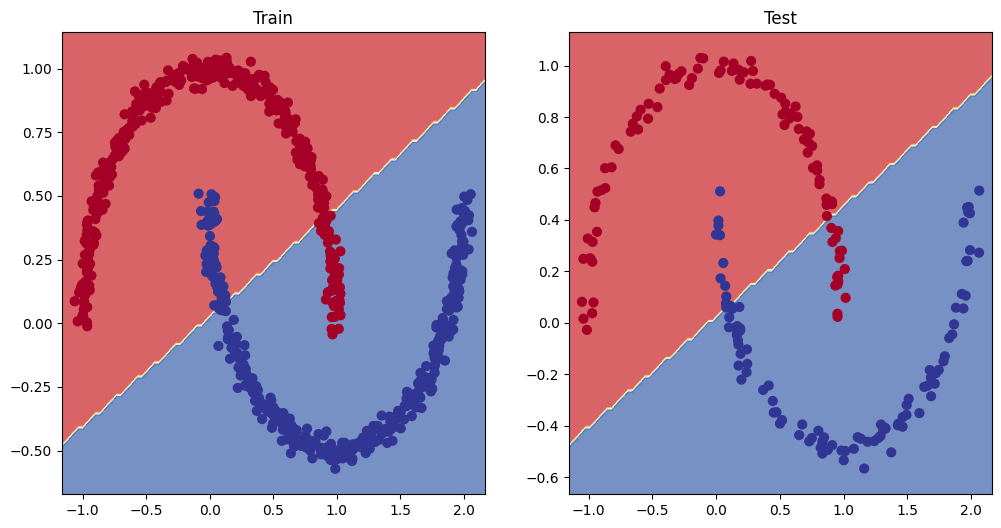

In [174]:
from helper_functions import plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In machine learning terms, our model is `underfitting`, meaning it's not learning predictive patterns from the data.

Let's also plot the loss graph: 


In [206]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, test_losses):
    """
    Plots training and testing loss curves.

    Args:
        train_losses (list): Loss values from training
        test_losses (list): Loss values from testing
    """
    epochs = range(len(train_losses))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()


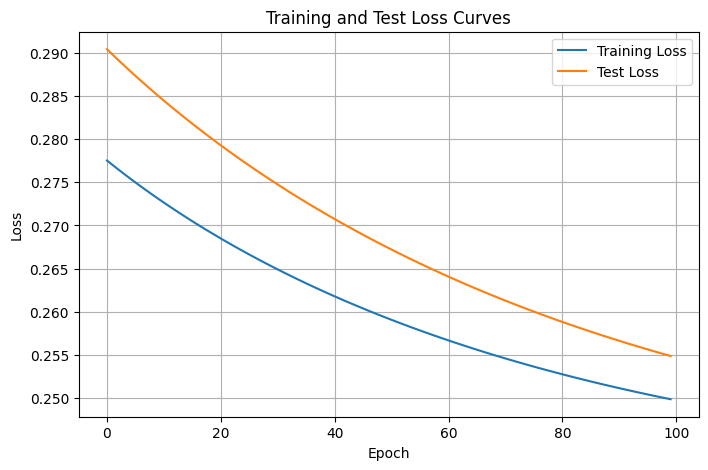

In [208]:
plot_loss_curves(train_losses, test_losses)

## Improving an Underfitting Model

Let’s try to address our model’s **underfitting** problem.

Focusing specifically on the **model itself** (not the data), there are several common techniques we can use to increase its capacity to learn more complex patterns.

### Model Improvement Techniques

| Model improvement technique* | What does it do? |
| ----- | ----- |
| **Add more layers** | Each additional layer can increase the model’s ability to learn hierarchical and more complex patterns. Models with more layers are often described as being *deeper*. |
| **Add more hidden units** | Increasing the number of hidden units in a layer can improve the model’s representational power. Models with more units per layer are often described as being *wider*. |
| **Train for longer (more epochs)** | Giving the model more passes over the training data can allow it to learn patterns it may not have captured initially. |
| **Change activation functions** | Linear activations limit what a model can learn. Non-linear activation functions allow the model to capture more complex relationships in the data. |
| **Adjust the learning rate** | The learning rate controls how much the model updates its parameters each step. Too high can cause instability; too low can slow or stall learning. |
| **Change the loss function** | The loss function defines what “good performance” means. Using an inappropriate loss function can prevent the model from learning effectively. |
| **Use transfer learning** | Leveraging a pretrained model from a related task can significantly improve performance, especially with limited data. |

> **Note:** Because these settings are chosen *before* training and tuned manually, they are referred to as **hyperparameters**.

---

### Improving the Model

To increase the model’s learning capacity, we’ll make the following changes:

- Add an extra hidden layer  
- Increase the number of hidden units from **5 → 10**  
- Train for longer, increasing epochs from **100 → 1000**

We’ll follow the same modeling steps as before, but with these updated hyperparameters, and then evaluate whether these changes help reduce underfitting and improve performance.


In [209]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = ModelV1().to(device)
model_1

ModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [210]:
model = model_1
epochs = 1000

# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

Epoch: 0 | Loss: 0.71976, Accuracy: 30.75% | Test loss: 0.70134, Test acc: 45.50%
Epoch: 10 | Loss: 0.58674, Accuracy: 79.62% | Test loss: 0.58552, Test acc: 78.00%
Epoch: 20 | Loss: 0.47594, Accuracy: 79.62% | Test loss: 0.48700, Test acc: 77.00%
Epoch: 30 | Loss: 0.39832, Accuracy: 81.00% | Test loss: 0.41841, Test acc: 77.00%
Epoch: 40 | Loss: 0.35499, Accuracy: 81.62% | Test loss: 0.37773, Test acc: 78.00%
Epoch: 50 | Loss: 0.32886, Accuracy: 82.62% | Test loss: 0.35055, Test acc: 80.50%
Epoch: 60 | Loss: 0.31010, Accuracy: 83.75% | Test loss: 0.32940, Test acc: 82.00%
Epoch: 70 | Loss: 0.29513, Accuracy: 84.75% | Test loss: 0.31171, Test acc: 83.50%
Epoch: 80 | Loss: 0.28276, Accuracy: 85.00% | Test loss: 0.29670, Test acc: 85.50%
Epoch: 90 | Loss: 0.27260, Accuracy: 85.62% | Test loss: 0.28413, Test acc: 86.50%
Epoch: 100 | Loss: 0.26443, Accuracy: 86.25% | Test loss: 0.27384, Test acc: 87.50%
Epoch: 110 | Loss: 0.25803, Accuracy: 87.00% | Test loss: 0.26561, Test acc: 87.50%
Epo

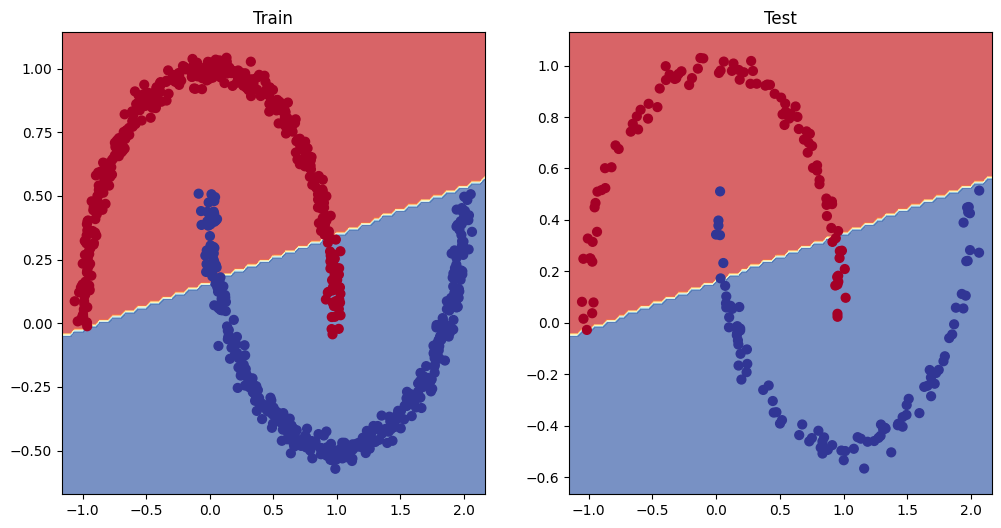

In [211]:
train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

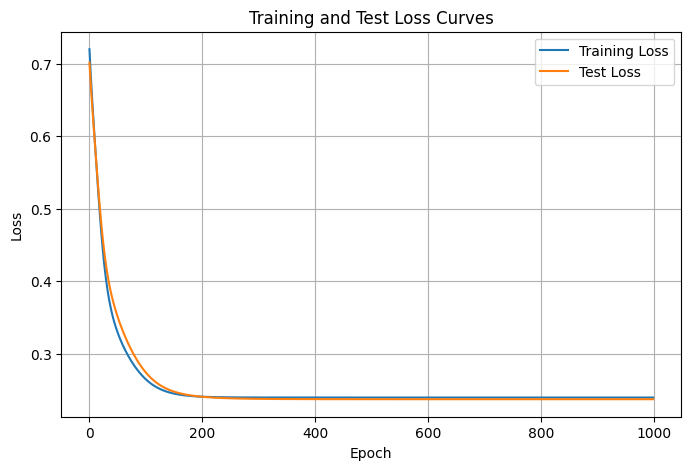

In [212]:
plot_loss_curves(train_losses, test_losses)

**Let's try adding activation functions:**

In [215]:
# Build model with non-linear activation function
from torch import nn
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = ModelV2().to(device)
print(model_2)

ModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Epoch: 0 | Loss: 0.31079, Accuracy: 86.88% | Test loss: 0.31853, Test acc: 87.00%
Epoch: 10 | Loss: 0.28831, Accuracy: 87.25% | Test loss: 0.29474, Test acc: 89.00%
Epoch: 20 | Loss: 0.27077, Accuracy: 87.88% | Test loss: 0.27567, Test acc: 89.50%
Epoch: 30 | Loss: 0.25681, Accuracy: 88.50% | Test loss: 0.26022, Test acc: 90.00%
Epoch: 40 | Loss: 0.24546, Accuracy: 88.75% | Test loss: 0.24739, Test acc: 90.00%
Epoch: 50 | Loss: 0.23604, Accuracy: 89.00% | Test loss: 0.23661, Test acc: 90.50%
Epoch: 60 | Loss: 0.22801, Accuracy: 89.12% | Test loss: 0.22740, Test acc: 90.50%
Epoch: 70 | Loss: 0.22095, Accuracy: 89.50% | Test loss: 0.21939, Test acc: 90.50%
Epoch: 80 | Loss: 0.21462, Accuracy: 89.75% | Test loss: 0.21231, Test acc: 91.50%
Epoch: 90 | Loss: 0.20890, Accuracy: 89.88% | Test loss: 0.20598, Test acc: 92.00%


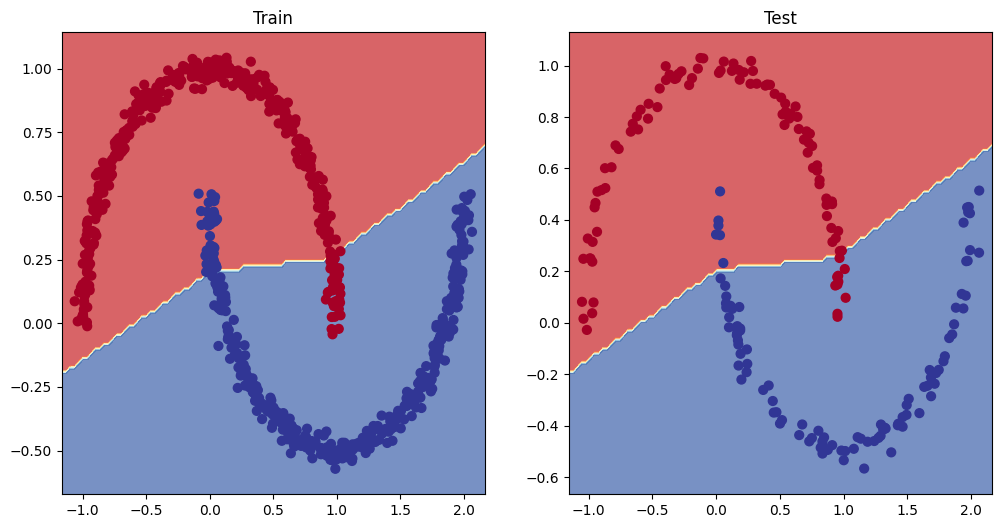

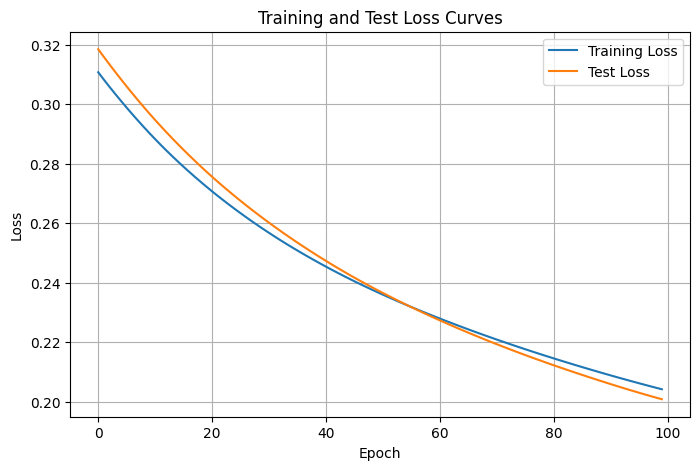

In [217]:
model = model_2
epochs = 100

# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plot_loss_curves(train_losses, test_losses)

Let's train more ...


Epoch: 0 | Loss: 0.68812, Accuracy: 50.00% | Test loss: 0.68863, Test acc: 50.00%
Epoch: 10 | Loss: 0.66466, Accuracy: 58.13% | Test loss: 0.66790, Test acc: 59.00%
Epoch: 20 | Loss: 0.63938, Accuracy: 71.00% | Test loss: 0.64516, Test acc: 68.00%
Epoch: 30 | Loss: 0.60971, Accuracy: 72.88% | Test loss: 0.61825, Test acc: 65.50%
Epoch: 40 | Loss: 0.57542, Accuracy: 74.88% | Test loss: 0.58717, Test acc: 67.50%
Epoch: 50 | Loss: 0.53599, Accuracy: 77.12% | Test loss: 0.55077, Test acc: 70.50%
Epoch: 60 | Loss: 0.49249, Accuracy: 78.38% | Test loss: 0.51005, Test acc: 74.00%
Epoch: 70 | Loss: 0.44844, Accuracy: 80.50% | Test loss: 0.46772, Test acc: 75.00%
Epoch: 80 | Loss: 0.40754, Accuracy: 81.38% | Test loss: 0.42747, Test acc: 79.50%
Epoch: 90 | Loss: 0.37173, Accuracy: 83.12% | Test loss: 0.39100, Test acc: 81.50%
Epoch: 100 | Loss: 0.34147, Accuracy: 83.62% | Test loss: 0.35894, Test acc: 83.00%
Epoch: 110 | Loss: 0.31638, Accuracy: 84.62% | Test loss: 0.33133, Test acc: 84.50%
Epo

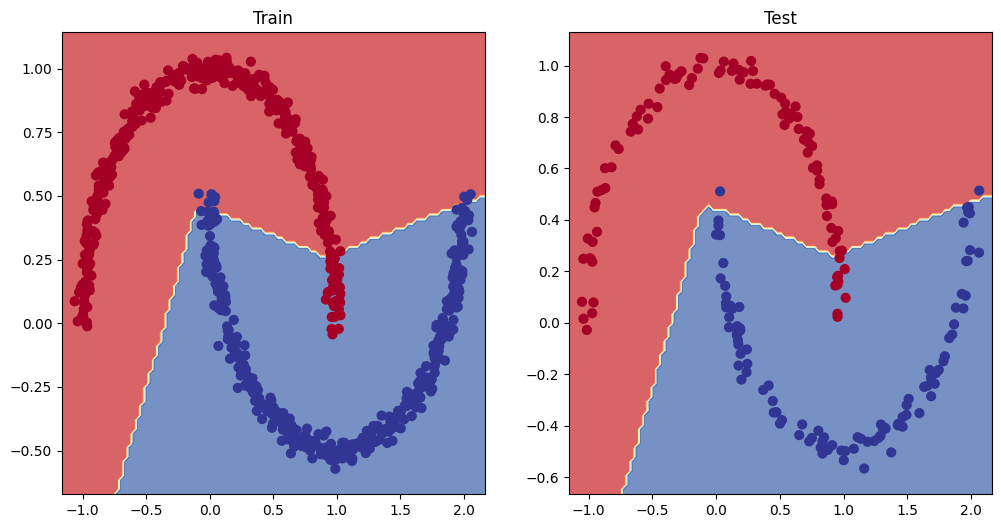

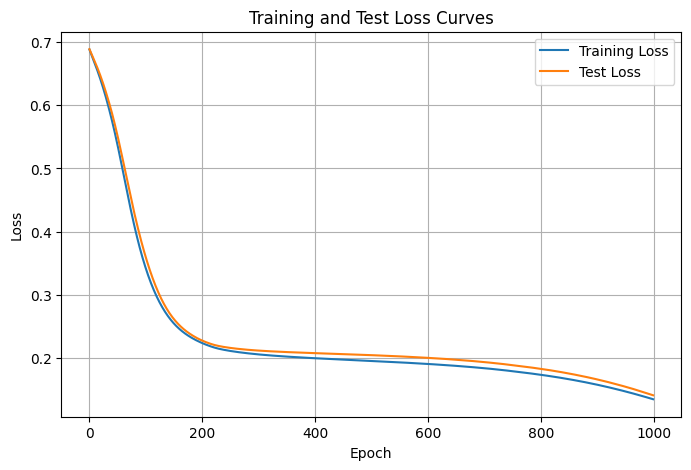

In [219]:
epochs = 1000
model = ModelV2().to(device) # reset model
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plot_loss_curves(train_losses, test_losses)

**This is the reason why Activation Function is necessary:**
![Neuron](https://towardsdatascience.com/wp-content/uploads/2021/12/1hkYlTODpjJgo32DoCOWN5w.png)

An example of a neural network with activation functions is shown below.

![NN with activation](https://lamarr-institute.org/wp-content/uploads/deepLearn_2_EN.png)
 
> `Note:` 
When looking at a neural network diagram, it is generally assumed that each neuron applies an activation function to its weighted input, unless stated otherwise.


Epoch: 0 | Loss: 0.68997, Accuracy: 50.00% | Test loss: 0.69176, Test acc: 50.00%
Epoch: 10 | Loss: 0.67816, Accuracy: 50.00% | Test loss: 0.68106, Test acc: 50.00%
Epoch: 20 | Loss: 0.66469, Accuracy: 50.00% | Test loss: 0.66873, Test acc: 50.00%
Epoch: 30 | Loss: 0.64807, Accuracy: 69.88% | Test loss: 0.65353, Test acc: 67.50%
Epoch: 40 | Loss: 0.62733, Accuracy: 69.50% | Test loss: 0.63462, Test acc: 68.00%
Epoch: 50 | Loss: 0.60236, Accuracy: 71.88% | Test loss: 0.61201, Test acc: 68.50%
Epoch: 60 | Loss: 0.57485, Accuracy: 73.75% | Test loss: 0.58720, Test acc: 70.50%
Epoch: 70 | Loss: 0.54689, Accuracy: 74.62% | Test loss: 0.56208, Test acc: 71.50%
Epoch: 80 | Loss: 0.52004, Accuracy: 75.88% | Test loss: 0.53757, Test acc: 72.00%
Epoch: 90 | Loss: 0.49492, Accuracy: 77.25% | Test loss: 0.51394, Test acc: 72.00%
Epoch: 100 | Loss: 0.47158, Accuracy: 78.00% | Test loss: 0.49155, Test acc: 73.00%
Epoch: 110 | Loss: 0.45015, Accuracy: 78.75% | Test loss: 0.47047, Test acc: 75.00%
Epo

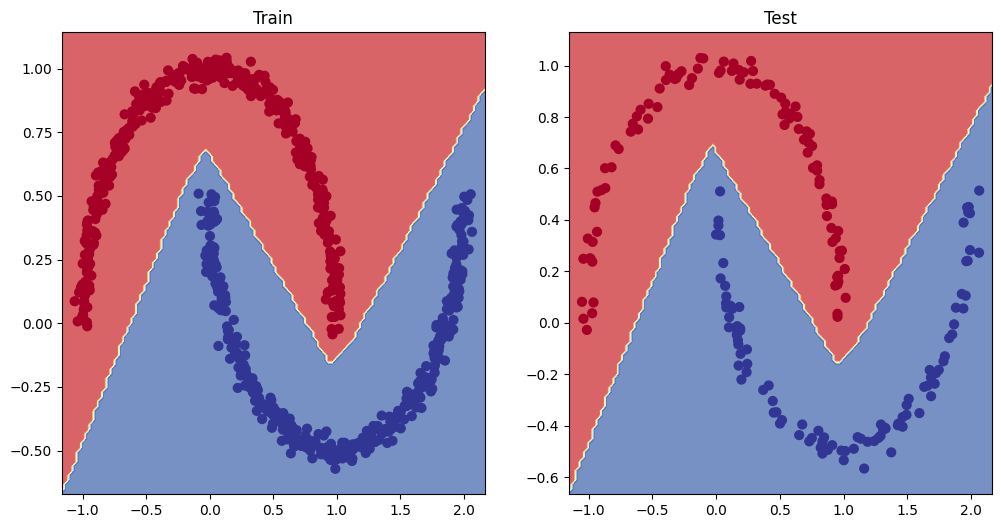

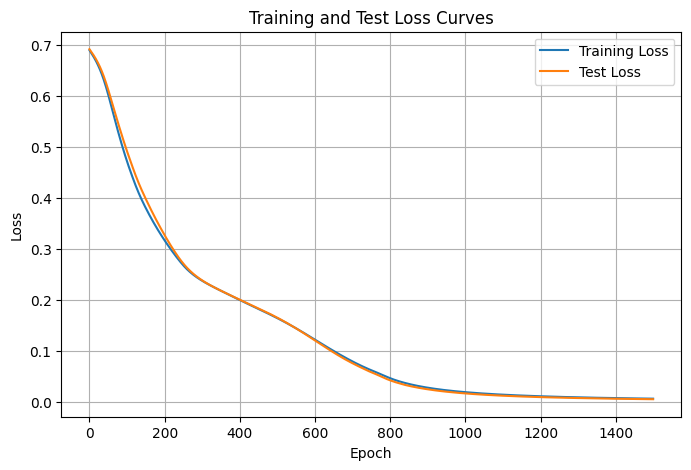

In [220]:
model = ModelV2().to(device) # reset model
epochs = 1500
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

train_losses, acc_list, test_losses, test_acc = train_and_test_loop(
    model=model,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer
)

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plot_loss_curves(train_losses, test_losses)